In [4]:
import ee
import geemap
import wxee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib
from tensorflow.keras.models import model_from_json

# Initialize Earth Engine
ee.Initialize(project='rahul-gis')
wxee.Initialize()

# Initialize global variables
targetProjection = ee.Projection('EPSG:32643')
ERA5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
DEM = ee.Image("USGS/SRTMGL1_003")
Modis = ee.ImageCollection("MODIS/061/MYD11A1")
MODIS_Ref_250 = ee.ImageCollection("MODIS/061/MYD09GQ")
MODIS_Ref_500 = ee.ImageCollection("MODIS/061/MYD09GA")
L8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
L9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

# Define Landsat bands
L89_Bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']

scaler_X = joblib.load(r"/Users/rahulharod/Library/CloudStorage/OneDrive-IndianInstituteofTechnologyBombay/Model/ANN_72_scaler_X.pkl")
scaler_y = joblib.load(r"/Users/rahulharod/Library/CloudStorage/OneDrive-IndianInstituteofTechnologyBombay/Model/ANN_72_scaler_y.pkl")


with open(r"/Users/rahulharod/Library/CloudStorage/OneDrive-IndianInstituteofTechnologyBombay/Model/ANN_72_Model_Arc.json", "r") as json_file:
    loaded_model_json = json_file.read()

best_model = model_from_json(loaded_model_json)
best_model.load_weights(r"/Users/rahulharod/Library/CloudStorage/OneDrive-IndianInstituteofTechnologyBombay/Model/ANN_72_Model_Weights.h5")

bands=['DOY','Elevation', 'SR_B4','sur_refl_b07', 'SSRDH', 'NDVI','NDBI','LST_Day_1km']

location = 'Bharatpur'
GTS = ee.FeatureCollection("users/rahul_harod/LST_Ground_Data_Locations")
ROI = GTS.filter(ee.Filter.eq('Location', location))
roi = ROI.geometry()
print(roi.getInfo())
Clip_roi = roi.buffer(20000).bounds()

# Landsat upscale function
def LandsatUpscale(img):
    return img.reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024).reproject(crs=targetProjection, scale=100)

# Downsampled LST function
def downsampledLST(img, clip_roi):
    return img.resample('bilinear').reproject(crs=targetProjection, scale=100).clip(clip_roi)

def NDVI_NDBI_NDWI(img):
    ndvi=img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndbi=img.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    ndwi=img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return img.addBands([ndvi,ndbi,ndwi])

# Cloud mask function
def cloudMask(img):
    qaBand = img.select(['QA_PIXEL'])
    cloudBitMask = 1 << 3  # Bit 3 represents cloud
    cloudShadowBitMask = 1 << 4  # Bit 4 represents cloud shadow
    cloudMask = qaBand.bitwiseAnd(cloudBitMask).neq(0)
    cloudShadowMask = qaBand.bitwiseAnd(cloudShadowBitMask).neq(0)
    combinedMask = cloudMask.Or(cloudShadowMask)
    return img.updateMask(combinedMask.Not())

# Apply scaling factors function
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True).select(['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']).set('Landsat_Time', ee.Date(image.get('system:time_start')).format('YYYY-MM-dd HH:mm'))

def addBandsToModis(img):
    thermalBands = img.select('LST_Day_1km').multiply(0.02)
    opticalBands = img.select('sur_refl_b.*').multiply(0.0001)
    return img.addBands([thermalBands, opticalBands], None, True)

def calculateTimeDifference(modisImage, landsatImage):
    modisDate = ee.Date(modisImage.date())
    landsatDate = ee.Date(landsatImage.date())
    return landsatDate.difference(modisDate, 'day').abs()

# Function to find closest Landsat image
def findClosestLandsat(modisImage,landsat):
    modisDate = ee.Date(modisImage.date())
    landsatImagesInRange = landsat.filterDate(modisDate.advance(-60, 'day'), modisDate.advance(60, 'day'))
    sortedLandsat = landsatImagesInRange.map(lambda landsatImage: landsatImage.set('time_difference', calculateTimeDifference(modisImage, landsatImage))).sort('time_difference')
    closestLandsatImage = ee.Image(sortedLandsat.first())
    # return closestLandsatImage.set('MODIS_Time', modisDate.format('YYYY-MM-dd HH:mm')).set('DATE_ACQUIRED', modisDate.format('YYYY-MM-dd')).set('Landsat_Time', closestLandsatImage.get('Landsat_Time'))
    return modisImage.addBands(closestLandsatImage).set('MODIS_Time', modisDate.format('YYYY-MM-dd HH:mm')).set('DATE_ACQUIRED', modisDate.format('YYYY-MM-dd')).set('Landsat_Time', closestLandsatImage.get('Landsat_Time'))

def downscale(date, clip_roi,Modis,MODIS_Ref_250,MODIS_Ref_500,ERA5):
    elevation=DEM.clip(clip_roi)
    elevation=LandsatUpscale(elevation).rename('Elevation')
    DOY=pd.to_datetime(date).day_of_year
    DOY_image = ee.Image.constant(DOY).clip(clip_roi).reproject(elevation.projection()).rename('DOY')
    DOY_image=LandsatUpscale(DOY_image)
    
    start=ee.Date(date)
    end=start.advance(2,'day')

    Landsat_Coll = L8.merge(L9).sort('system:time_start').filterDate(start, end).filterBounds(clip_roi)
    landsat = Landsat_Coll.map(cloudMask).map(LandsatUpscale).map(applyScaleFactors).map(NDVI_NDBI_NDWI)
    Modis = Modis.filterDate(start, end)
    MODIS_Ref_250 = MODIS_Ref_250.filterDate(start, end).select(['sur_refl_b01', 'sur_refl_b02'])
    MODIS_Ref_500 = MODIS_Ref_500.filterDate(start, end).select(['sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'])
    Modis = Modis.combine(MODIS_Ref_250).combine(MODIS_Ref_500)

    Modis = Modis.map(addBandsToModis).map(lambda img: downsampledLST(img, clip_roi)).select(['sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'LST_Day_1km'])
    ERA5 = ERA5.filterDate(start, end).select('surface_solar_radiation_downwards_hourly').filter(ee.Filter.eq('hour', 8)).map(lambda img: downsampledLST(img, clip_roi)).map(lambda image: image.set('system:time_start', ee.Date(image.get('system:time_start')).update(hour=0, minute=0, second=0).millis()))
    filterJoin = ee.Filter.equals(leftField='system:time_start', rightField='system:time_start')
    simpleJoin = ee.Join.inner()
    modis_ERA = ee.ImageCollection(simpleJoin.apply(Modis, ERA5, filterJoin))
    modis_ERA_Coll = modis_ERA.map(lambda feature: ee.Image.cat(feature.get('primary'), feature.get('secondary')))
    modisWithClosestLandsat = modis_ERA_Coll.map(lambda modisImage: findClosestLandsat(modisImage,landsat).addBands([elevation,DOY_image]))
    return modisWithClosestLandsat

def Predictions(modisWithClosestLandsat):
    data=modisWithClosestLandsat.first().wx.to_xarray(scale=100,crs='EPSG:4326')
    df = data.to_dataframe()
    df.reset_index(inplace=True)
    df.drop(columns=['spatial_ref'], inplace=True)
    df.rename(columns={'surface_solar_radiation_downwards_hourly': 'SSRDH'}, inplace=True)
    df1=df[bands]
    df1.dropna(inplace=True)

    X_test = scaler_X.transform(df1[bands])
    y_pred = best_model.predict(X_test)
    df1['ANN_LST'] = scaler_y.inverse_transform(y_pred)

    merged_df = df.merge(df1['ANN_LST'], how='left', left_index=True, right_index=True)
    merged_df.set_index(['y', 'x'], inplace=True)
    merged_df = merged_df.to_xarray()
    data['ANN_LST'] = merged_df['ANN_LST']
    data['ANN_LST'].attrs = {'long_name': 'ANN_LST', 'AREA_OR_POINT': 'Area', 'grid_mapping': 'spatial_ref'}

    # fig = plt.figure() 
    # min_=np.nanpercentile(df1['ANN_LST'],1)
    # max_=np.nanpercentile(df1['ANN_LST'],99)

    # f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5))
    # im1 = ax1.imshow(data['LST_Day_1km'], cmap='jet',vmin=min_, vmax=max_)
    # im2 = ax2.imshow(data['ST_B10'], cmap='jet',vmin=min_, vmax=max_)
    # im3 = ax3.imshow(data['ANN_LST'], cmap='jet',vmin=min_, vmax=max_)

    # ax1.set_title('MODIS LST')
    # ax2.set_title('Landsat LST')
    # ax3.set_title('ANN LST')

    # f.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    # f.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
    # f.colorbar(im3, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)

    # plt.tight_layout()
    # plt.show()
    return data
modisWithClosestLandsat=downscale('2023-01-16',Clip_roi,Modis,MODIS_Ref_250,MODIS_Ref_500,ERA5)
data=Predictions(modisWithClosestLandsat)

/Users/rahulharod/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'type': 'Point', 'coordinates': [77.4524984390619, 27.203000145306625]}


Downloading:   0%|          | 0.00/16.0M [00:00<?, ?iB/s]

 538/5617 [=>............................] - ETA: 1s

/var/folders/sw/4ng28l5j6mvd1qlg_7p5d6z80000gn/T/ipykernel_29420/2007068346.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


5617/5617 [==============================] - 2s 264us/step


/var/folders/sw/4ng28l5j6mvd1qlg_7p5d6z80000gn/T/ipykernel_29420/2007068346.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ANN_LST'] = scaler_y.inverse_transform(y_pred)


In [9]:
data = data.isel(time=0)
data

<xarray.Dataset>
Dimensions:                                   (x: 448, y: 402)
Coordinates:
    time                                      datetime64[ns] 2023-01-16
  * x                                         (x) float64 77.25 77.25 ... 77.65
  * y                                         (y) float64 27.38 27.38 ... 27.02
    spatial_ref                               int64 0
Data variables: (12/19)
    sur_refl_b03                              (y, x) float64 0.0445 ... 0.0457
    sur_refl_b04                              (y, x) float64 0.1074 ... 0.0947
    sur_refl_b05                              (y, x) float64 0.3035 ... 0.2879
    sur_refl_b06                              (y, x) float64 0.1498 ... 0.1644
    sur_refl_b07                              (y, x) float64 0.06548 ... 0.0794
    LST_Day_1km                               (y, x) float64 291.6 ... 291.5
    ...                                        ...
    NDVI                                      (y, x) float32 0.696 ... 0.7014
    NDBI                                      (y, x) float32 -0.4741 ... -0.4316
    NDWI                                      (y, x) float32 -0.6205 ... -0.6339
    Elevation                                 (y, x) float64 187.7 ... 175.6
    DOY                                       (y, x) float64 16.0 16.0 ... 16.0
    ANN_LST                                   (y, x) float32 292.2 ... 292.8
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

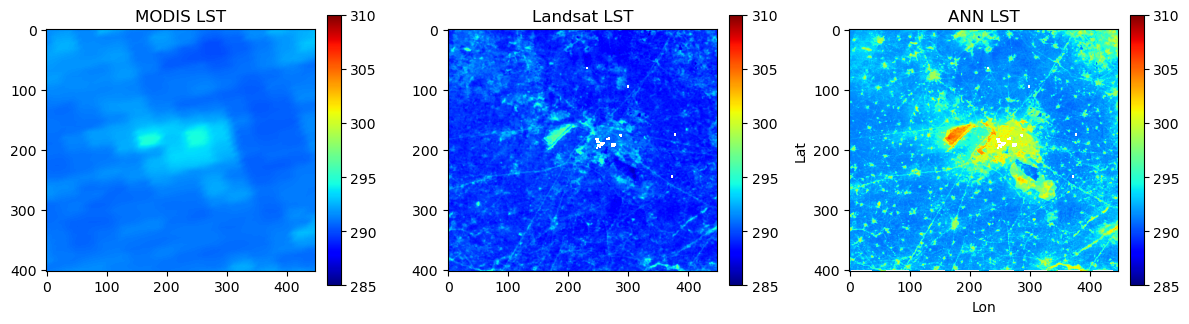

In [11]:
# Define min and max values for colorbar
min_ = 285
max_ = 310

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot MODIS LST
ax1 = axes[0]
im1 = ax1.imshow(data['LST_Day_1km'], cmap='jet', vmin=min_, vmax=max_)
ax1.set_title('MODIS LST')
plt.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)

# Plot Landsat LST
ax2 = axes[1]
im2 = ax2.imshow(data['ST_B10'], cmap='jet', vmin=min_, vmax=max_)
ax2.set_title('Landsat LST')
plt.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)

# Plot ANN LST
ax3 = axes[2]
im3 = ax3.imshow(data['ANN_LST'], cmap='jet', vmin=min_, vmax=max_)
ax3.set_title('ANN LST')
plt.colorbar(im3, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)

# Display lat and lon
plt.xlabel('Lon')
plt.ylabel('Lat')

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
data[['ANN_LST','LST_Day_1km']]

<xarray.Dataset>
Dimensions:      (y: 402, x: 448)
Coordinates:
    time         datetime64[ns] 2023-01-16
  * x            (x) float64 77.25 77.25 77.25 77.25 ... 77.65 77.65 77.65 77.65
  * y            (y) float64 27.38 27.38 27.38 27.38 ... 27.03 27.02 27.02 27.02
    spatial_ref  int64 0
Data variables:
    ANN_LST      (y, x) float32 292.2 292.2 292.2 292.4 ... 292.4 292.4 292.8
    LST_Day_1km  (y, x) float64 291.6 291.6 291.6 291.6 ... 291.5 291.5 291.5
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [15]:
!pip install leafmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 8.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 4.4 MB/s eta 0:00:00
